In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F

import torch
import os
import random

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight

from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from eeg_feature_extraction.eeg_utils import *
from neural_nets.models import *
from neural_nets.utils import *

%matplotlib inline

# set random seed for reproducibility
random.seed(42)

GPU not available, CPU used


## Binary classification

In [2]:
classification = 'binary'

In [3]:
# load all word embeddings into memory
all_embeddings = load_embeddings(classification)

embeddings_nca_nr = all_embeddings[0]
embeddings_nca_tsr = all_embeddings[1]
embeddings_randomforest_nr = all_embeddings[2]
embeddings_randomforest_tsr = all_embeddings[3]

assert embeddings_randomforest_nr.shape == embeddings_nca_nr.shape
assert embeddings_randomforest_tsr.shape == embeddings_nca_tsr.shape

# get indices for held out test sentences
held_out_sents_nr = get_held_out_sents('task2')
held_out_sents_tsr = get_held_out_sents('task3')

# get number of sentences per task without held out test sentences
n_sents_nr = len(get_sent_lens_per_task('task2', held_out_sents_nr))
n_sents_tsr = len(get_sent_lens_per_task('task3', held_out_sents_tsr))

In [4]:
# reshape word embeddings into tensors of size N (number of sents) x T (sequence length per task) x D (embeddings dim)
embeddings_randomforest_nr_seq = reshape_into_tensor(embeddings_randomforest_nr, 'task2')
embeddings_randomforest_tsr_seq = reshape_into_tensor(embeddings_randomforest_tsr, 'task3')
embeddings_nca_nr_seq = reshape_into_tensor(embeddings_nca_nr, 'task2')
embeddings_nca_tsr_seq = reshape_into_tensor(embeddings_nca_tsr, 'task3')

assert embeddings_randomforest_nr_seq.shape == embeddings_nca_nr_seq.shape
assert embeddings_randomforest_tsr_seq.shape == embeddings_nca_tsr_seq.shape
assert embeddings_randomforest_nr_seq.shape[0] == embeddings_nca_nr_seq.shape[0] == n_sents_nr
assert embeddings_randomforest_tsr_seq.shape[0] == embeddings_nca_tsr_seq.shape[0] == n_sents_tsr

In [5]:
# vertically stack sequences on top of each other to create whole sequence data set
all_seq_randomforest = torch.cat((embeddings_randomforest_nr_seq , embeddings_randomforest_tsr_seq ), 0)
all_seq_nca = torch.cat((embeddings_nca_nr_seq , embeddings_nca_tsr_seq ), 0)

assert all_seq_randomforest.shape == all_seq_nca.shape

In [6]:
# create labels vector for binary classification task
labels_nr_bi, labels_tsr_bi = torch.zeros(n_sents_nr, dtype = torch.double), torch.ones(n_sents_tsr, dtype = torch.double)
all_labels_bi = torch.cat((labels_nr_bi, labels_tsr_bi), 0)

In [7]:
# split data set into 80% train, 10% val, 10% test
n_seq_total = n_sents_nr + n_sents_tsr
n_val_seq = n_seq_total // 10 * 2
n_train_seq = n_seq_total - n_val_seq

val_indices = list(set(random.sample(list(range(n_seq_total)), k = n_val_seq)))
train_indices = [i for i in range(n_seq_total) if i not in val_indices]

# split entire val set into dev and test
test_indices = val_indices[n_val_seq//2:]
val_indices = val_indices[:n_val_seq//2]

In [8]:
# create train and dev sets for binary and multiclass classification tasks
X_train_rf = all_seq_randomforest[train_indices]
X_train_nca = all_seq_nca[train_indices]

y_train_bi =  all_labels_bi[train_indices]

X_val_rf = all_seq_randomforest[val_indices]
X_val_nca = all_seq_nca[val_indices]

y_val_bi =  all_labels_bi[val_indices]

X_test_rf = all_seq_randomforest[test_indices]
X_test_nca = all_seq_nca[test_indices]

y_test_bi =  all_labels_bi[test_indices]

In [10]:
# define hyperparameters
seq_length = 20
embedding_dim = 45
n_layers = 2
batch_size = 32
output_size = 1
hidden_dim = 50
lr = 0.01

epochs = 10

In [11]:
## Batches for binary classification ##

# create data loaders for both embeddings extracted via random forest and nca embeddings
train_loader_rf_bi, val_loader_rf_bi = get_data_batches(X_train_rf, y_train_bi, X_val_rf, y_val_bi, batch_size)
train_loader_nca_bi , val_loader_nca_bi = get_data_batches(X_train_nca, y_train_bi, X_val_nca, y_val_bi, batch_size)

In [12]:
## Test data loader for binary classification ##

test_loader_nca_bi, test_loader_rf_bi = get_data_batches(X_test_nca, y_test_bi, X_test_rf, y_test_bi, batch_size)

In [39]:
# instantiate the model with pre-defined hyperparameters
model = VanillaBiLSTM(embedding_dim, hidden_dim, output_size, n_layers, task = classification)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# binary cross-entropy for binary classification task, cross-entropy loss for multiclass 
criterion = loss_func(classification)
optimizer = get_optim(model, lr)

In [40]:
train_loader = train_loader_nca_bi
val_loader = val_loader_nca_bi
test_loader = test_loader_nca_bi

In [41]:
train_losses, train_accs, train_f1_scores, val_losses, val_accs, val_f1_scores, model = fit(model, criterion, optimizer, train_loader, val_loader, classification, epochs)

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/10  Step: 10  Train Loss: 0.132  Train Acc: 0.850  Train F1: 0.814  Val Loss: 0.193  Val Acc: 0.938  Val F1: 0.936 


C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 2/10  Step: 20  Train Loss: 0.032  Train Acc: 1.000  Train F1: 1.000  Val Loss: 0.029  Val Acc: 1.000  Val F1: 1.000 
Validation loss decreased (inf --> 0.193135).  Saving model ...

Epoch: 2/10  Step: 30  Train Loss: 0.015  Train Acc: 0.990  Train F1: 0.990  Val Loss: 0.137  Val Acc: 0.969  Val F1: 0.969 
Validation loss decreased (0.193135 --> 0.193135).  Saving model ...

Epoch: 3/10  Step: 40  Train Loss: 0.008  Train Acc: 1.000  Train F1: 1.000  Val Loss: 0.219  Val Acc: 0.953  Val F1: 0.953 
Validation loss decreased (0.193135 --> 0.164942).  Saving model ...

Epoch: 3/10  Step: 50  Train Loss: 0.010  Train Acc: 0.996  Train F1: 0.996  Val Loss: 0.008  Val Acc: 1.000  Val F1: 1.000 
Validation loss decreased (0.164942 --> 0.164942).  Saving model ...

Epoch: 4/10  Step: 60  Train Loss: 0.009  Train Acc: 1.000  Train F1: 1.000  Val Loss: 0.004  Val Acc: 1.000  Val F1: 1.000 
Validation loss decreased (0.164942 --> 0.112596).  Saving model ...

Epoch: 5/10  Step: 70  Train L

In [42]:
print(np.max(train_accs))
print(np.max(val_accs))

1.0
1.0


In [43]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

Test loss: 0.000
Test accuracy: 100.000%
Test F1-score: 100.000%


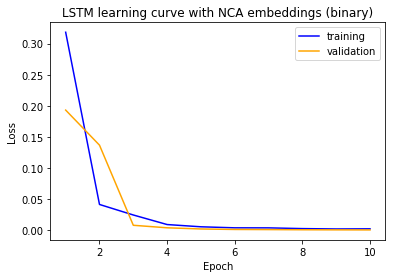

In [44]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with NCA embeddings (binary)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [37]:
print(np.max(train_accs))
print(np.max(val_accs))

0.9980469
1.0


In [35]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

Test loss: 0.023
Test accuracy: 100.000%
Test F1-score: 100.000%


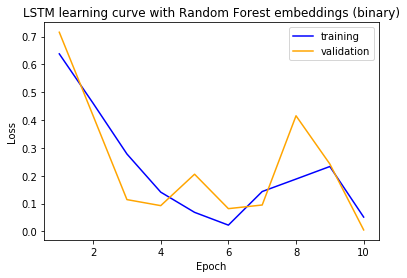

In [38]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with Random Forest embeddings (binary)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

## Multiclass classification

In [45]:
classification = 'multiclass'
classes = ['NR_No_Rel','NR_Rel', 'TSR_No_Rel', 'TSR_Rel']

In [46]:
indices_relations_task2, indices_no_relations_task2, indices_relations_task3, indices_no_relations_task3 = get_rel_labels()

In [47]:
# load all word embeddings into memory
all_embeddings = load_embeddings(classification)

embeddings_nca_nr = all_embeddings[0]
embeddings_nca_tsr = all_embeddings[1]

# get indices for held out test sentences
held_out_sents_nr = get_held_out_sents('task2')
held_out_sents_tsr = get_held_out_sents('task3')

# get number of sentences per task without held out test sentences
n_sents_nr = len(get_sent_lens_per_task('task2', held_out_sents_nr))
n_sents_tsr = len(get_sent_lens_per_task('task3', held_out_sents_tsr))

# get indices for (dev) sentences with and without relations respectively
indices_rel_nr = [idx for idx in indices_relations_task2 if idx not in held_out_sents_nr]
indices_no_rel_nr = [idx for idx in indices_no_relations_task2 if idx not in held_out_sents_nr]
indices_rel_tsr = [idx for idx in indices_relations_task3 if idx not in held_out_sents_tsr]
indices_no_rel_tsr = [idx for idx in indices_no_relations_task3 if idx not in held_out_sents_tsr]

In [48]:
# reshape word embeddings into tensors of size N (number of sents) x T (sequence length per task) x D (embeddings dim)
embeddings_nca_nr_seq = reshape_into_tensor(embeddings_nca_nr, 'task2')
embeddings_nca_tsr_seq = reshape_into_tensor(embeddings_nca_tsr, 'task3')

assert embeddings_nca_nr_seq.shape[0] == n_sents_nr
assert embeddings_nca_tsr_seq.shape[0] == n_sents_tsr

In [49]:
# vertically stack sequences on top of each other to create whole sequence data set
all_seq_nca = torch.cat((embeddings_nca_nr_seq , embeddings_nca_tsr_seq ), 0)

In [50]:
# create labels vector for multiclass-classification task
labels_nr_multi = create_multiclass_labels(indices_rel_nr, indices_no_rel_nr, n_sents_nr, 'task2')
labels_tsr_multi = create_multiclass_labels(indices_rel_tsr, indices_no_rel_tsr, n_sents_tsr, 'task3')
all_labels_multi = torch.cat((labels_nr_multi, labels_tsr_multi), 0)

In [85]:
# split data set into 70% train, 15% val, 15% test
n_seq_total = n_sents_nr + n_sents_tsr
n_val_seq = n_seq_total // 10 * 3
n_train_seq = n_seq_total - n_val_seq

val_indices = list(set(random.sample(list(range(n_seq_total)), k = n_val_seq)))
train_indices = [i for i in range(n_seq_total) if i not in val_indices]

# split entire val set into dev and test
test_indices = val_indices[n_val_seq//2:]
val_indices = val_indices[:n_val_seq//2]

In [86]:
# create train and dev sets for binary and multiclass classification tasks
X_train_nca = all_seq_nca[train_indices]
y_train_multi = all_labels_multi[train_indices]

X_val_nca = all_seq_nca[val_indices]
y_val_multi = all_labels_multi[val_indices]

X_test_nca = all_seq_nca[test_indices]
y_test_multi = all_labels_multi[test_indices]

In [140]:
# define hyperparameters
seq_length = 20
embedding_dim = 45
n_layers = 3
batch_size = 16
output_size = 4
hidden_dim = 100
lr = 0.001

epochs = 50
print_every = 10
clip = 5
valid_loss_min = np.Inf

In [94]:
## Batches for multiclass classification ##

train_loader_nca_multi, val_loader_nca_multi = get_data_batches(X_train_nca, y_train_multi, X_val_nca, y_val_multi, batch_size)
test_loader_nca_multi, _= get_data_batches(X_test_nca, y_test_multi, X_val_nca, y_val_multi, batch_size)

In [141]:
# instantiate the model with pre-defined hyperparameters
model = VanillaBiLSTM(embedding_dim, hidden_dim, output_size, n_layers, task = classification)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# compute class weights for multiclass classification problem
weights = torch.from_numpy(class_weight.compute_class_weight('balanced', np.unique(y_train_multi), y_train_multi.numpy()))

# binary cross-entropy for binary classification task, cross-entropy loss for multiclass 
criterion = loss_func(classification, weight = weights)
optimizer = get_optim(model, lr)

In [96]:
train_loader = train_loader_nca_multi
val_loader = val_loader_nca_multi
test_loader = test_loader_nca_multi

In [142]:
train_losses, train_accs, train_f1_scores, val_losses, val_accs, val_f1_scores, model = fit(model, criterion, optimizer, train_loader, val_loader, classification, epochs)

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 1/80  Step: 10  Train Loss: 1.386  Train Acc: 0.262  Train F1: 0.221  Val Loss: 1.354  Val Acc: 0.396  Val F1: 0.285 


C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1/80  Step: 20  Train Loss: 1.003  Train Acc: 0.381  Train F1: 0.351  Val Loss: 1.012  Val Acc: 0.635  Val F1: 0.517 
Epoch: 2/80  Step: 30  Train Loss: 0.821  Train Acc: 0.688  Train F1: 0.605  Val Loss: 0.845  Val Acc: 0.542  Val F1: 0.469 
Validation loss decreased (inf --> 1.012154).  Saving model ...

Epoch: 2/80  Step: 40  Train Loss: 0.760  Train Acc: 0.625  Train F1: 0.595  Val Loss: 0.769  Val Acc: 0.427  Val F1: 0.351 
Validation loss decreased (1.012154 --> 1.012154).  Saving model ...

Epoch: 2/80  Step: 50  Train Loss: 0.736  Train Acc: 0.557  Train F1: 0.546  Val Loss: 0.712  Val Acc: 0.458  Val F1: 0.397 
Validation loss decreased (1.012154 --> 1.012154).  Saving model ...

Epoch: 3/80  Step: 60  Train Loss: 0.707  Train Acc: 0.656  Train F1: 0.674  Val Loss: 0.727  Val Acc: 0.604  Val F1: 0.550 
Validation loss decreased (1.012154 --> 0.862151).  Saving model ...

Epoch: 3/80  Step: 70  Train Loss: 0.750  Train Acc: 0.609  Train F1: 0.566  Val Loss: 0.708  Val Ac

Epoch: 30/80  Step: 850  Train Loss: 0.758  Train Acc: 0.542  Train F1: 0.559  Val Loss: 0.695  Val Acc: 0.542  Val F1: 0.413 
Validation loss decreased (0.709526 --> 0.709115).  Saving model ...

Epoch: 30/80  Step: 860  Train Loss: 0.687  Train Acc: 0.556  Train F1: 0.555  Val Loss: 0.692  Val Acc: 0.562  Val F1: 0.512 
Validation loss decreased (0.709115 --> 0.709115).  Saving model ...

Epoch: 30/80  Step: 870  Train Loss: 0.672  Train Acc: 0.542  Train F1: 0.547  Val Loss: 0.700  Val Acc: 0.594  Val F1: 0.486 
Validation loss decreased (0.709115 --> 0.709115).  Saving model ...

Epoch: 31/80  Step: 880  Train Loss: 0.722  Train Acc: 0.475  Train F1: 0.467  Val Loss: 0.697  Val Acc: 0.469  Val F1: 0.387 
Validation loss decreased (0.709115 --> 0.708824).  Saving model ...

Epoch: 31/80  Step: 890  Train Loss: 0.652  Train Acc: 0.528  Train F1: 0.524  Val Loss: 0.697  Val Acc: 0.552  Val F1: 0.486 
Validation loss decreased (0.708824 --> 0.708824).  Saving model ...

Epoch: 32/80  S

Epoch: 58/80  Step: 1670  Train Loss: 0.731  Train Acc: 0.559  Train F1: 0.551  Val Loss: 0.699  Val Acc: 0.469  Val F1: 0.399 
Validation loss decreased (0.702866 --> 0.702866).  Saving model ...

Epoch: 58/80  Step: 1680  Train Loss: 0.710  Train Acc: 0.535  Train F1: 0.532  Val Loss: 0.697  Val Acc: 0.458  Val F1: 0.326 
Validation loss decreased (0.702866 --> 0.702866).  Saving model ...

Epoch: 59/80  Step: 1690  Train Loss: 0.701  Train Acc: 0.500  Train F1: 0.510  Val Loss: 0.698  Val Acc: 0.438  Val F1: 0.364 
Validation loss decreased (0.702866 --> 0.702757).  Saving model ...

Epoch: 59/80  Step: 1700  Train Loss: 0.675  Train Acc: 0.469  Train F1: 0.473  Val Loss: 0.704  Val Acc: 0.365  Val F1: 0.232 
Validation loss decreased (0.702757 --> 0.702757).  Saving model ...

Epoch: 59/80  Step: 1710  Train Loss: 0.697  Train Acc: 0.449  Train F1: 0.451  Val Loss: 0.702  Val Acc: 0.417  Val F1: 0.332 
Validation loss decreased (0.702757 --> 0.702757).  Saving model ...

Epoch: 60/

In [132]:
print("Train accuracy: {}%".format(round(np.max(train_accs)*100, 3)))
print("Val accuracy: {}%".format(round(np.max(val_accs)*100, 3)))

Train accuracy: 65.179%
Val accuracy: 65.625%


In [133]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

Test loss: 0.831
Test accuracy: 62.500%
Test F1-score: 61.847%


In [120]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test loss: 0.714
Test accuracy: 62.500%
Test F1-score: 64.047%


In [145]:
y_hat = np.array([val for pred in preds for val in pred])
y_true = np.array([val for label in true_labels for val in label])

In [146]:
print(classification_report(y_true, y_hat, labels = np.unique(y_true), target_names = classes))

              precision    recall  f1-score   support

   NR_No_Rel       0.83      0.50      0.62        20
      NR_Rel       0.50      0.83      0.62        12
  TSR_No_Rel       0.23      0.36      0.28        14
     TSR_Rel       0.79      0.66      0.72        50

    accuracy                           0.60        96
   macro avg       0.59      0.59      0.56        96
weighted avg       0.68      0.60      0.62        96



In [135]:
print(classification_report(y_true, y_hat, labels = np.unique(y_true), target_names = classes))

              precision    recall  f1-score   support

   NR_No_Rel       0.63      0.60      0.62        20
      NR_Rel       0.38      0.42      0.40        12
  TSR_No_Rel       0.23      0.21      0.22        14
     TSR_Rel       0.78      0.80      0.79        50

    accuracy                           0.62        96
   macro avg       0.51      0.51      0.51        96
weighted avg       0.62      0.62      0.62        96



Normalized confusion matrix


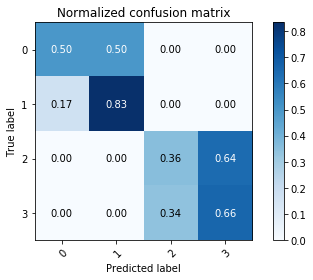

In [147]:
plot_confusion_matrix(y_true, y_hat, classes = np.unique(y_true), normalize = True)

Normalized confusion matrix


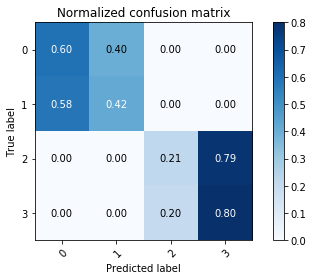

In [136]:
plot_confusion_matrix(y_true, y_hat, classes = np.unique(y_true), normalize = True)

Normalized confusion matrix


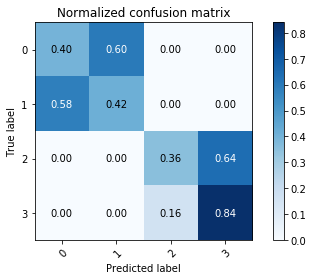

In [123]:
plot_confusion_matrix(y_true, y_hat, classes = np.unique(y_true), normalize = True)

Normalized confusion matrix


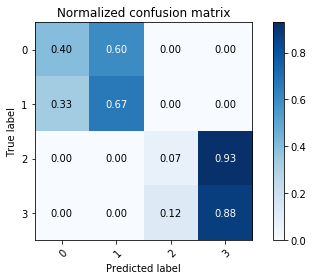

In [114]:
plot_confusion_matrix(y_true, y_hat, classes = np.unique(y_true), normalize = True)

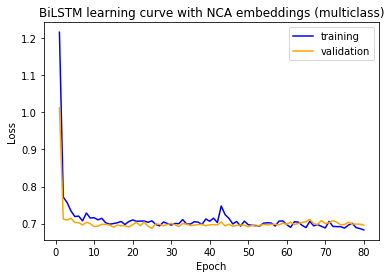

In [149]:
plt.plot(range(1,81), train_losses, color='blue')
plt.plot(range(1,81), val_losses, color='orange')
plt.title("BiLSTM learning curve with NCA embeddings (multiclass)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

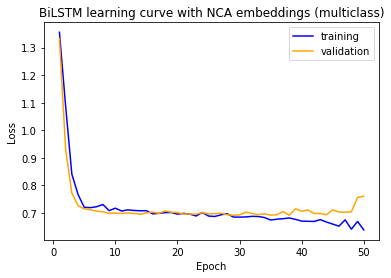

In [115]:
plt.plot(range(1,51), train_losses, color='blue')
plt.plot(range(1,51), val_losses, color='orange')
plt.title("BiLSTM learning curve with NCA embeddings (multiclass)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

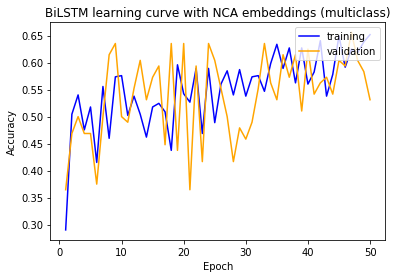

In [139]:
plt.plot(range(1,51), train_accs, color='blue')
plt.plot(range(1,51), val_accs, color='orange')
plt.title("BiLSTM learning curve with NCA embeddings (multiclass)")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')